# Reactor Kinetics Example 

Jialu Wang (jwang44@nd.edu) and Alex Dowling (adowling@nd.edu)

University of Notre Dame

This notebook conducts design of experiments for a reactor kinetics experiment with the Pyomo.DOE.
    

In [1]:
import matplotlib.pyplot as plt
from pyomo.environ import *
from pyomo.dae import *

import numpy as np
from scipy.interpolate import interp2d
import pandas as pd 

from DoE_package import *
from pyomo.contrib.sensitivity_toolbox.sens import sipopt

## Define Reaction Example Mathematical Model

Consider two chemical reactions that converts molecule $A$ to desired product $B$ and a less valuable side-product $C$.

$A \overset{k_1}{\rightarrow} B \overset{k_2}{\rightarrow} C$

Our ultimate goals is to design a large-scale continous reactor that maximizes the production of $B$. This general sequential reactions problem is widely applicable to CO$_2$ capture and industry more broadly (petrochemicals, pharmasuticals, etc.).

The rate laws for these two chemical reactions are:

$r_A = -k_1 C_A$

$r_B = k_1 C_A - k_2 C_B$

$r_C = k_2 C_B$

Here, $C_A$, $C_B$, and $C_C$ are the concentrations of each species. The rate constants $k_1$ and $k_2$ depend on temperature as follows:

$k_1 = A_1 \exp{\frac{-E_1}{R T}}$

$k_2 = A_2 \exp{\frac{-E_2}{R T}}$

$A_1, A_2, E_1$, and $E_2$ are fitted model parameters. $R$ is the ideal-gas constant and $T$ is absolute temperature.

Using the **CCSI$^2$ toolset**, we would like do the following perform:

Perform **uncertainty quantification** and **design of experiments** on a small-scale **batch reactor** to infer parameters $A_1$, $A_2$, $E_1$, and $E_2$.

### Batch reactor

The concenrations in a batch reactor evolve with time per the following differential equations:

$$ \frac{d C_A}{dt} = r_A = -k_1 C_A $$

$$ \frac{d C_B}{dt} = r_B = k_1 C_A - k_2 C_B $$

$$ \frac{d C_C}{dt} = r_C = k_2 C_B $$

This is a linear system of differential equations. Assuming the feed is only species $A$, i.e., 

$$C_A(t=0) = C_{A0} \quad C_B(t=0) = 0 \quad C_C(t=0) = 0$$

When the temperature is constant, it leads to the following analytic solution:

$$C_A(t) = C_{A,0} \exp(-k_1 t)$$

$$C_B(t) = \frac{k_1}{k_2 - k_1} C_{A,0} \left[\exp(-k_1 t) - \exp(-k_2 t) \right]$$

$$C_C(t) = C_{A,0} - \frac{k_2}{k_2 - k_1} C_{A,0} \exp(-k_1 t) + \frac{k_1}{k_2 - k_1} \exp(-k_2 t) C_{A,0} = C_{A,0} - C_{A}(t) - C_{B}(t)$$

In [2]:
from reactor_models import *

Three versions of this model is accomplished: 

Dynamic-DAE model: Temperature varying model discretized and integrated by Pyomo.DAE

Constant-DAE model: Temperature constant model discretized and integrated by Pyomo.DAE

Constant-analytical model: Temperature constant model discretized manually and using the analytical expressions for state variables.

In [3]:
# choose model from 'dynamic-DAE', 'constant-DAE', 'constant-analytical'
#model_opt = 'dynamic-DAE'
model_opt = 'constant-DAE'
#model_opt = 'constant-analytical'

if (model_opt=='dynamic-DAE'):
    createmod = create_model_dae
    disc = discretizer
    t_control = [0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1]
    
elif (model_opt=='constant-DAE'):
    createmod = create_model_dae_const
    disc = discretizer
    t_control = [0]
    
elif (model_opt=='constant-analytical'):
    createmod = create_model_alge
    disc = None
    t_control = [0]

    
# design variable and its control time set
dv_pass = {'CA0': [0],'T': t_control}
    
# Define measurement time points
t_measure = [0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1]

In [4]:
# Define parameter nominal value 
parameter_dict = {'A1': 84.79085853498033, 'A2': 371.71773413976416, 'E1': 7.777032028026428, 'E2': 15.047135137500822}

def generate_exp(t_set, CA0, T):  
    '''Generate experiments. 
    t_set: time control set for T.
    CA0: CA0 value
    T: A list of T 
    '''
    assert(len(t_set)==len(T)), 'T should have the same length as t_set'
    
    T_con_initial = {}
    for t, tim in enumerate(t_set):
        T_con_initial[tim] = T[t]
        
    dv_dict_overall = {'CA0': {0: CA0},'T': T_con_initial}
    return dv_dict_overall

In [7]:
# empty prior
#prior_all = np.zeros((4,4))


# add prior information
prior_5_300 = pd.read_csv('fim_5_300_scale.csv')
prior_5_300_500 = pd.read_csv('fim_5_300_500_scale.csv')

prior_all = prior_5_300_500


prior_pass=np.asarray(prior_all)

#L_initials = np.linalg.cholesky(prior_pass)
#print(L_initials)

print('The prior information FIM:', prior_pass)
print('Prior Det:', np.linalg.det(prior_pass))
print('Eigenvalue of the prior experiments FIM:', np.linalg.eigvals(prior_pass))
print('Eigenvalue of the prior experiments FIM:', np.linalg.eigh(prior_pass)[1])

The prior information FIM: [[  28.67892806    5.41249739  -81.73674601  -24.02377324]
 [   5.41249739   26.40935036  -12.41816477 -139.23992532]
 [ -81.73674601  -12.41816477  240.46276004   58.76422806]
 [ -24.02377324 -139.23992532   58.76422806  767.25584508]]
Prior Det: 140189.67370995492
Eigenvalue of the prior experiments FIM: [8.00463185e+02 2.60471503e+02 4.84545259e-01 1.38765050e+00]
Eigenvalue of the prior experiments FIM: [[-0.77629273 -0.54211788  0.31871243 -0.0435912 ]
 [ 0.56614148 -0.80478003 -0.01425817 -0.177791  ]
 [-0.25919275 -0.19059651 -0.94009108  0.11278677]
 [ 0.09834911 -0.14869526  0.12019924  0.97661114]]


## Compute FIM 

This method computes an MBDoE optimization problem with no Degree of Freedom.

In [8]:
# choose from 'simultaneous', 'sequential', 'sipopt'
#sensi_opt = 'simultaneous_finite'
#sensi_opt = 'sequential_finite'
sensi_opt = 'sequential_sipopt'

# Define experiments
if (model_opt=='dynamic-DAE'):
    exp1 = generate_exp(t_control, 5, [570.21, 300, 300, 300, 300, 300, 300, 300, 300])
else: 
    exp1 = generate_exp(t_control, 5, [500])

print('Design variable:', exp1)

Design variable: {'CA0': {0: 5}, 'T': {0: 500}}


In [9]:
doe_object = DesignOfExperiments(parameter_dict, dv_pass,
                                 ['CA','CB','CC'], t_measure, createmod,
                                prior_FIM=prior_pass, discretize_model=disc)


if_s = True
result = doe_object.compute_FIM(exp1,mode=sensi_opt, FIM_store_name = 'dynamic.csv', scale_nominal_param_value=if_s, formula='central')


if sensi_opt == 'simultaneous_finite':
    result.extract_FIM(doe_object.m, doe_object.design_timeset,
                                                          doe_object.square_result, doe_object.obj_opt)
else:
    result.calculate_FIM(doe_object.jac, doe_object.design_values)

Sensitivity information is scaled by its corresponding parameter nominal value.
perturb names are: ['A1_pert', 'A2_pert', 'E1_pert', 'E2_pert']
Perturbation parameters are set:
A1_pert :  83.94294994963053
A2_pert :  371.71773413976416
E1_pert :  7.777032028026428
E2_pert :  15.047135137500822
Ipopt 3.13.3: run_sens=yes


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.13.3, running with linear solver ma27.

Number of nonzeros in equality constraint Jacobian...:     3371
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      677

Total number of variables........

perturb names are: ['A1_pert', 'A2_pert', 'E1_pert', 'E2_pert']
Perturbation parameters are set:
A1_pert :  84.79085853498033
A2_pert :  368.0005567983665
E1_pert :  7.777032028026428
E2_pert :  15.047135137500822
Ipopt 3.13.3: run_sens=yes


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.13.3, running with linear solver ma27.

Number of nonzeros in equality constraint Jacobian...:     3371
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      677

Total number of variables............................:      873
                     variables with only lower bou

perturb names are: ['A1_pert', 'A2_pert', 'E1_pert', 'E2_pert']
Perturbation parameters are set:
A1_pert :  84.79085853498033
A2_pert :  371.71773413976416
E1_pert :  7.699261707746163
E2_pert :  15.047135137500822
Ipopt 3.13.3: run_sens=yes


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.13.3, running with linear solver ma27.

Number of nonzeros in equality constraint Jacobian...:     3371
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      677

Total number of variables............................:      873
                     variables with only lower bo

perturb names are: ['A1_pert', 'A2_pert', 'E1_pert', 'E2_pert']
Perturbation parameters are set:
A1_pert :  84.79085853498033
A2_pert :  371.71773413976416
E1_pert :  7.777032028026428
E2_pert :  14.896663786125814
Ipopt 3.13.3: run_sens=yes


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.13.3, running with linear solver ma27.

Number of nonzeros in equality constraint Jacobian...:     3371
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      677

Total number of variables............................:      873
                     variables with only lower bo

Existed information has been added.
FIM: [[  34.82842588    8.98465164  -93.24075867  -36.95321685]
 [   8.98465164   34.72021956  -19.10067921 -169.32118928]
 [ -93.24075867  -19.10067921  261.98359165   82.95164765]
 [ -36.95321685 -169.32118928   82.95164765  876.13524382]]
Trace: 1207.6674809121441
Determinant: 560758.4831259692
Condition number: 1016.698290931099
Minimal eigen value: 0.9075848753712111
Eigen values: [9.22739992e+02 2.81642456e+02 9.07584875e-01 2.37744860e+00]
Eigen vectors: [[ 0.05653299 -0.32983836 -0.77051799  0.54250595]
 [ 0.1886326   0.01601913  0.56994741  0.79957556]
 [-0.13533434  0.9325324  -0.26619805  0.20299395]
 [-0.97103366 -0.14605948  0.10295907  0.15861803]]


In [10]:
print('======Result summary======')
print('Four design criteria log10() value:')
print('A-optimality:', np.log10(result.trace))
print('D-optimality:', np.log10(result.det))
print('E-optimality:', np.log10(result.min_eig))
print('Modified E-optimality:', np.log10(result.cond))

======Result summary======
Four design criteria log10() value:
A-optimality: 3.081947372129281
D-optimality: 5.748775852289656
E-optimality: -0.042112750113627556
Modified E-optimality: 3.0071920935090257


### Run sequential DOE automatically

This method runs a series of experiments in a row.

In [11]:
exp1 = generate_exp(t_control, 5, [300])
exp2 = generate_exp(t_control, 5, [500.92])
exp3 = generate_exp(t_control, 5, [528])
exp4 = generate_exp(t_control, 5, [546.8])
exp5 = generate_exp(t_control, 5, [562])

In [12]:

exp_all = [exp1, exp2, exp3, exp4, exp5]


doe_object = DesignOfExperiments(parameter_dict, dv_pass,
                                 ['CA','CB','CC'], t_measure, createmod,
                                prior_FIM=prior_pass, discretize_model=disc)

# choose from 'simultaneous', 'sequential', 'sipopt'
#sensi_opt = 'simultaneous_finite'
sensi_opt = 'sequential_finite'
#sensi_opt = 'sequential_sipopt'
if_s = True
result = doe_object.sequential_exp(exp_all, mode=sensi_opt, tee_option=True,
                                    scale_nominal_param_value=if_s, formula='central')

Sensitivity information is scaled by its corresponding parameter nominal value.
========This is the No. 0  experiment.========
Design variables: {'CA0': {0: 5}, 'T': {0: 300}}
Sensitivity information is scaled by its corresponding parameter nominal value.
Ipopt 3.13.3: linear_solver=ma57
halt_on_ampl_error=yes


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.13.3, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:     2979
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      289

Total number of variables..................

Ipopt 3.13.3: linear_solver=ma57
halt_on_ampl_error=yes


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.13.3, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:     2979
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      289

Total number of variables............................:      869
                     variables with only lower bounds:      289
                variables with lower and upper bounds:       96
                     variables with only upper bounds:        0
Total number of equality constraints.......

Ipopt 3.13.3: linear_solver=ma57
halt_on_ampl_error=yes


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.13.3, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:     2979
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      289

Total number of variables............................:      869
                     variables with only lower bounds:      289
                variables with lower and upper bounds:       96
                     variables with only upper bounds:        0
Total number of equality constraints.......


Number of Iterations....: 31

                                   (scaled)                 (unscaled)
Objective...............:   0.0000000000000000e+00    0.0000000000000000e+00
Dual infeasibility......:   0.0000000000000000e+00    0.0000000000000000e+00
Constraint violation....:   3.5396396924625151e-10    3.5396396924625151e-10
Complementarity.........:   0.0000000000000000e+00    0.0000000000000000e+00
Overall NLP error.......:   3.5396396924625151e-10    3.5396396924625151e-10


Number of objective function evaluations             = 38
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 38
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 33
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 31
Total CPU secs in IPOPT (w/o function evaluations)   =      0.034
Total CPU secs in NLP function evaluations

Ipopt 3.13.3: linear_solver=ma57
halt_on_ampl_error=yes


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.13.3, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:     2979
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      289

Total number of variables............................:      869
                     variables with only lower bounds:      289
                variables with lower and upper bounds:       96
                     variables with only upper bounds:        0
Total number of equality constraints.......

Ipopt 3.13.3: linear_solver=ma57
halt_on_ampl_error=yes


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.13.3, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:     2979
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      289

Total number of variables............................:      869
                     variables with only lower bounds:      289
                variables with lower and upper bounds:       96
                     variables with only upper bounds:        0
Total number of equality constraints.......

Ipopt 3.13.3: linear_solver=ma57
halt_on_ampl_error=yes


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.13.3, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:     2979
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      289

Total number of variables............................:      869
                     variables with only lower bounds:      289
                variables with lower and upper bounds:       96
                     variables with only upper bounds:        0
Total number of equality constraints.......

Ipopt 3.13.3: linear_solver=ma57
halt_on_ampl_error=yes


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.13.3, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:     2979
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      289

Total number of variables............................:      869
                     variables with only lower bounds:      289
                variables with lower and upper bounds:       96
                     variables with only upper bounds:        0
Total number of equality constraints.......

Ipopt 3.13.3: linear_solver=ma57
halt_on_ampl_error=yes


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.13.3, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:     2979
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      289

Total number of variables............................:      869
                     variables with only lower bounds:      289
                variables with lower and upper bounds:       96
                     variables with only upper bounds:        0
Total number of equality constraints.......

Ipopt 3.13.3: linear_solver=ma57
halt_on_ampl_error=yes


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.13.3, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:     2979
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      289

Total number of variables............................:      869
                     variables with only lower bounds:      289
                variables with lower and upper bounds:       96
                     variables with only upper bounds:        0
Total number of equality constraints.......

Ipopt 3.13.3: linear_solver=ma57
halt_on_ampl_error=yes


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.13.3, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:     2979
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      289

Total number of variables............................:      869
                     variables with only lower bounds:      289
                variables with lower and upper bounds:       96
                     variables with only upper bounds:        0
Total number of equality constraints.......

Ipopt 3.13.3: linear_solver=ma57
halt_on_ampl_error=yes


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.13.3, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:     2979
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      289

Total number of variables............................:      869
                     variables with only lower bounds:      289
                variables with lower and upper bounds:       96
                     variables with only upper bounds:        0
Total number of equality constraints.......

Ipopt 3.13.3: linear_solver=ma57
halt_on_ampl_error=yes


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.13.3, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:     2979
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      289

Total number of variables............................:      869
                     variables with only lower bounds:      289
                variables with lower and upper bounds:       96
                     variables with only upper bounds:        0
Total number of equality constraints.......

Ipopt 3.13.3: linear_solver=ma57
halt_on_ampl_error=yes


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.13.3, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:     2979
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      289

Total number of variables............................:      869
                     variables with only lower bounds:      289
                variables with lower and upper bounds:       96
                     variables with only upper bounds:        0
Total number of equality constraints.......

Ipopt 3.13.3: linear_solver=ma57
halt_on_ampl_error=yes


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.13.3, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:     2979
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      289

Total number of variables............................:      869
                     variables with only lower bounds:      289
                variables with lower and upper bounds:       96
                     variables with only upper bounds:        0
Total number of equality constraints.......

Ipopt 3.13.3: linear_solver=ma57
halt_on_ampl_error=yes


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.13.3, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:     2979
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      289

Total number of variables............................:      869
                     variables with only lower bounds:      289
                variables with lower and upper bounds:       96
                     variables with only upper bounds:        0
Total number of equality constraints.......

Ipopt 3.13.3: linear_solver=ma57
halt_on_ampl_error=yes


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.13.3, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:     2979
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      289

Total number of variables............................:      869
                     variables with only lower bounds:      289
                variables with lower and upper bounds:       96
                     variables with only upper bounds:        0
Total number of equality constraints.......

Ipopt 3.13.3: linear_solver=ma57
halt_on_ampl_error=yes


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.13.3, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:     2979
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      289

Total number of variables............................:      869
                     variables with only lower bounds:      289
                variables with lower and upper bounds:       96
                     variables with only upper bounds:        0
Total number of equality constraints.......

Ipopt 3.13.3: linear_solver=ma57
halt_on_ampl_error=yes


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.13.3, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:     2979
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      289

Total number of variables............................:      869
                     variables with only lower bounds:      289
                variables with lower and upper bounds:       96
                     variables with only upper bounds:        0
Total number of equality constraints.......

In [13]:
print('=======Result summary=======')
for i in range(len(exp_all)):
    print('The ', i+1,'th experiment has optimality log10() values:')
    print('A-optimality:', np.log10(result[0][i].trace))
    print('D-optimality:', np.log10(result[0][i].det))
    print('E-optimality:', np.log10(result[0][i].min_eig))
    print('Modified E-optimality:', np.log10(result[0][i].cond))

=======Result summary=======
The  1 th experiment has optimality log10() values:
A-optimality: 3.29689373129363
D-optimality: 5.749123827110235
E-optimality: -0.29964150858495253
Modified E-optimality: 3.4698543224317957
The  2 th experiment has optimality log10() values:
A-optimality: 3.327246742969606
D-optimality: 6.350625457960553
E-optimality: -0.013857523926267818
Modified E-optimality: 3.2179519402375574
The  3 th experiment has optimality log10() values:
A-optimality: 3.348792387089486
D-optimality: 6.690041312590909
E-optimality: 0.1406932135450932
Modified E-optimality: 3.087166444109095
The  4 th experiment has optimality log10() values:
A-optimality: 3.3659365095541167
D-optimality: 6.925560558536682
E-optimality: 0.24481023207384423
Modified E-optimality: 3.001834323221942
The  5 th experiment has optimality log10() values:
A-optimality: 3.3802584633897554
D-optimality: 7.104914718930726
E-optimality: 0.3222497253540566
Modified E-optimality: 2.9400127239293687


### Run 1D analysis

Run 1D sensitivity analysis with one changing design variable

Note: this method can only deal with constant T problems

In [14]:
# Define experiments
if (model_opt=='dynamic-DAE'):
    exp1 = generate_exp(t_control, 5, [570.21, 300, 300, 300, 300, 300, 300, 300, 300])
else: 
    exp1 = generate_exp(t_control, 5, [500])


In [15]:
doe_object = DesignOfExperiments(parameter_dict, dv_pass,
                                 ['CA','CB','CC'], t_measure, createmod,
                                prior_FIM=prior_pass, discretize_model=disc)

# choose from 'simultaneous', 'sequential', 'sipopt'
#sensi_opt = 'simultaneous_finite'
#sensi_opt = 'sequential_finite'
sensi_opt = 'sequential_sipopt'
if_s = True
result = doe_object.sensitivity_analysis_1D(exp1, {'T':[688,690]}, sensitivity_step=0.4, compare_opt='ME',
                                            mode=sensi_opt, tee_option=False,
                                    scale_nominal_param_value=if_s, formula='central')

Sensitivity information is scaled by its corresponding parameter nominal value.
Sensitivity analysis is for  ['T']  at the range  [[688, 690]]
At the points: [688.  688.4 688.8 689.2 689.6]
This is the  0 -th iteration
Design variables for this run: {'CA0': {0: 5}, 'T': {0: 688.0}}
Sensitivity information is scaled by its corresponding parameter nominal value.
perturb names are: ['A1_pert', 'A2_pert', 'E1_pert', 'E2_pert']
Perturbation parameters are set:
A1_pert :  84.70606767644534
A2_pert :  371.71773413976416
E1_pert :  7.777032028026428
E2_pert :  15.047135137500822
perturb names are: ['A1_pert', 'A2_pert', 'E1_pert', 'E2_pert']
Perturbation parameters are set:
A1_pert :  84.79085853498033
A2_pert :  371.34601640562437
E1_pert :  7.777032028026428
E2_pert :  15.047135137500822
perturb names are: ['A1_pert', 'A2_pert', 'E1_pert', 'E2_pert']
Perturbation parameters are set:
A1_pert :  84.79085853498033
A2_pert :  371.71773413976416
E1_pert :  7.769254995998401
E2_pert :  15.04713513

Existed information has been added.
FIM: [[  31.19390974    7.03338821  -85.14802534  -28.27756427]
 [   7.03338821   28.43641135  -14.61671413 -144.5596506 ]
 [ -85.14802534  -14.61671413  245.08976257   64.5339995 ]
 [ -28.27756427 -144.5596506    64.5339995   781.21668649]]
Trace: 1085.9367701574088
Determinant: 342306.00259180367
Condition number: 1196.9605977351102
Minimal eigen value: 0.683076629406871
Eigen values: [8.17615811e+02 2.65327878e+02 6.83076629e-01 2.31000502e+00]
Eigen vectors: [[ 0.04986207 -0.32439006 -0.71003437  0.62300567]
 [ 0.18122354  0.0127468   0.65245458  0.73572995]
 [-0.12189547  0.93666857 -0.23867148  0.22545378]
 [-0.97458365 -0.13137958  0.11484834  0.14048475]]
The result list: [1194.5425566602246, 1195.148087968523, 1195.7529423283, 1196.357114309498, 1196.9605977351102]


=======Result summary=======
The biggest criterion value is: 1196.9605977351102  at: 689.5999999999999
The smallest criterion value is: 1194.5425566602246  at: 688.0


Text(0, 0.5, 'Design criteria')

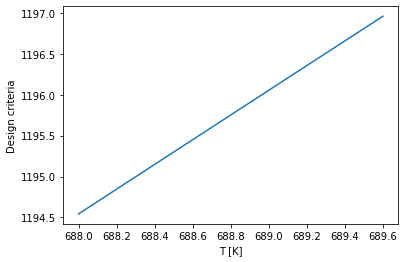

In [16]:
vary_range = list(result.keys())
result_list = list(result.values())

index_max = result_list.index(max(result_list))
index_min = result_list.index(min(result_list))

print('=======Result summary=======')
print('The biggest criterion value is:', max(result_list), ' at:', vary_range[index_max])
print('The smallest criterion value is:', min(result_list), ' at:', vary_range[index_min])

plt.plot(vary_range, result_list)
plt.xlabel('T [K]')
plt.ylabel('Design criteria')

## Optimization

In [17]:
doe_object = DesignOfExperiments(parameter_dict, dv_pass, 
                                 ['CA','CB','CC'], t_measure, createmod,
                                 prior_FIM=prior_pass, discretize_model=disc)

square_result, optimize_result = doe_object.optimize_doe(exp1, if_optimize=True, if_cho=True, scale_nominal_param_value=True, obj_opt='det', L_initial=None)


Sensitivity information is scaled by its corresponding parameter nominal value.
Ipopt 3.13.3: linear_solver=ma57
halt_on_ampl_error=yes


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.13.3, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:    24280
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1930

Total number of variables............................:     6414
                     variables with only lower bounds:     2316
                variables with lower and upper bounds:       96
                     variab

FIM: [[  31.19391557    7.03339196  -85.14802973  -28.2775692 ]
 [   7.03339196   28.43641665  -14.61671733 -144.55965845]
 [ -85.14802973  -14.61671733  245.08976375   64.53400122]
 [ -28.2775692  -144.55965845   64.53400122  781.21669121]]
Trace: 1085.936787183226
Determinant: 342307.05601205427
Condition number: 1196.9590568982903
Minimal eigen value: 0.6830775159226116
Eigen values: [8.17615819e+02 2.65327881e+02 6.83077516e-01 2.31000908e+00]
Eigen vectors: [[ 0.04986208 -0.32439007 -0.71003426  0.62300578]
 [ 0.18122355  0.01274679  0.6524547   0.73572984]
 [-0.12189547  0.93666857 -0.23867145  0.22545384]
 [-0.97458365 -0.13137959  0.11484837  0.14048474]]
Model objective: 12.743463437887634
Objective(determinant) is: 342307.056029055
Solution of  CA0  : [5]
Solution of  T  : [689.5999999999999]
======problem solver output======
converged
Ipopt 3.13.3: linear_solver=ma57
halt_on_ampl_error=yes


******************************************************************************
This 

In [18]:
print('======Result summary======')
print('This optimization is solved with status:', optimize_result.status)
print('It gives solution:', optimize_result.solution)
print('The log10(OF) optimized is:', optimize_result.obj_value)
print('The result FIM is:', optimize_result.FIM)

======Result summary======
This optimization is solved with status: converged
It gives solution: {'CA0': [5.0], 'T': [300.0000242851759]}
The log10(OF) optimized is: 13.237846622081737
The result FIM is: [[  51.20654061    7.25310602 -151.97486781  -35.12719512]
 [   7.25310602   44.50764054  -18.15692555 -248.41790943]
 [-151.97486781  -18.15692555  459.45595083   93.38314749]
 [ -35.12719512 -248.41790943   93.38314749 1425.87232729]]


## heatmap 

In [19]:
design_ranges = {'CA0':list(np.linspace(1,5,9)),  'T': list(np.linspace(300,700,9))}

dv_apply_time = {'CA0': [0], 'T': t_control}

# Define experiments
if (model_opt=='dynamic-DAE'):
    exp1 = generate_exp(t_control, 5, [570.21, 300, 300, 300, 300, 300, 300, 300, 300])
else: 
    exp1 = generate_exp(t_control, 5, [500])

In [20]:
doe_object = DesignOfExperiments(parameter_dict, dv_pass, 
                                 ['CA','CB','CC'], t_measure, createmod,
                                 prior_FIM=prior_pass, discretize_model=disc)

all_fim = doe_object.run_grid_search(exp1, design_ranges, dv_apply_time, 
                                     mode='sequential_finite', 
                                    scale_nominal_param_value=True
                                    )

Sensitivity information is scaled by its corresponding parameter nominal value.
=======This is the  1 th iteration=======
Design variable values of this iteration: {'CA0': {0: 1.0}, 'T': {0: 300.0}}
Sensitivity information is scaled by its corresponding parameter nominal value.
Existed information has been added.
FIM: [[  29.58003272    5.48612156  -84.54627162  -24.46790912]
 [   5.48612156   27.13328151  -12.64771469 -143.60704229]
 [ -84.54627162  -12.64771469  249.22249067   60.14898186]
 [ -24.46790912 -143.60704229   60.14898186  793.6004921 ]]
Trace: 1099.5362969977725
Determinant: 151638.4943213679
Condition number: 1703.5708820968514
Minimal eigen value: 0.48581739042109506
Eigen values: [8.27624360e+02 2.70029455e+02 4.85817390e-01 1.39666420e+00]
Eigen vectors: [[ 0.04300749 -0.31822906 -0.77652374  0.54211761]
 [ 0.17730502  0.01420751  0.56599113  0.80499386]
 [-0.1117473   0.94040674 -0.25890023  0.19004834]
 [-0.97684483 -0.1190108   0.09816107  0.1482397 ]]
This is the 

Existed information has been added.
FIM: [[  28.77447266    5.4733019   -81.86441559  -24.18097488]
 [   5.4733019    26.4829594   -12.4994136  -139.4302313 ]
 [ -81.86441559  -12.4994136   240.63335596   58.97428567]
 [ -24.18097488 -139.4302313    58.97428567  767.74785482]]
Trace: 1063.638642847519
Determinant: 146507.48646152133
Condition number: 1624.9104501935346
Minimal eigen value: 0.49299236417422976
Eigen values: [8.01068444e+02 2.60653941e+02 4.92992364e-01 1.42326479e+00]
Eigen vectors: [[ 0.04382893 -0.31893711 -0.7717461   0.54842146]
 [ 0.17791815  0.01419374  0.57277173  0.80004764]
 [-0.11313087  0.93996168 -0.25773099  0.19299787]
 [-0.97653754 -0.12062212  0.09957529  0.14801858]]
This is the  9  run out of  81 run.
The code has run 12.6645 seconds.
Estimated remaining time: 101.3162 seconds
=======This is the  10 th iteration=======
Design variable values of this iteration: {'CA0': {0: 1.5}, 'T': {0: 300.0}}
Sensitivity information is scaled by its corresponding par

Existed information has been added.
FIM: [[  28.89390341    5.54930753  -82.02400255  -24.37747694]
 [   5.54930753   26.57497071  -12.60097464 -139.66811378]
 [ -82.02400255  -12.60097464  240.84660087   59.23685769]
 [ -24.37747694 -139.66811378   59.23685769  768.362867  ]]
Trace: 1064.6783419866704
Determinant: 154556.86878195836
Condition number: 1592.9075104447347
Minimal eigen value: 0.5033721886008624
Eigen values: [8.01825340e+02 2.60881801e+02 5.03372189e-01 1.46782923e+00]
Eigen vectors: [[ 0.0441257  -0.3192171  -0.76637353  0.55572023]
 [ 0.17807683  0.01411373  0.58045733  0.79445499]
 [-0.11356021  0.93979995 -0.25600742  0.19580686]
 [-0.97644541 -0.12114987  0.10100051  0.14722759]]
This is the  18  run out of  81 run.
The code has run 25.9627 seconds.
Estimated remaining time: 90.8694 seconds
=======This is the  19 th iteration=======
Design variable values of this iteration: {'CA0': {0: 2.0}, 'T': {0: 300.0}}
Sensitivity information is scaled by its corresponding par

Existed information has been added.
FIM: [[  29.06110646    5.65571543  -82.24742429  -24.65257981]
 [   5.65571543   26.70378654  -12.74316009 -140.00114925]
 [ -82.24742429  -12.74316009  241.14514372   59.60445848]
 [ -24.65257981 -140.00114925   59.60445848  769.22388402]]
Trace: 1066.1339207407643
Determinant: 166109.9551245936
Condition number: 1551.1500791407132
Minimal eigen value: 0.5176066466705693
Eigen values: [8.02885591e+02 2.61200453e+02 5.17606647e-01 1.53027057e+00]
Eigen vectors: [[ 0.04454043 -0.31960751 -0.75938699  0.56497663]
 [ 0.1782985   0.01400273  0.59021965  0.78718126]
 [-0.11415988  0.93957357 -0.25377291  0.19942001]
 [-0.9763162  -0.12188714  0.10281766  0.1462147 ]]
This is the  27  run out of  81 run.
The code has run 39.0597 seconds.
Estimated remaining time: 78.1194 seconds
=======This is the  28 th iteration=======
Design variable values of this iteration: {'CA0': {0: 2.5}, 'T': {0: 300.0}}
Sensitivity information is scaled by its corresponding para

Existed information has been added.
FIM: [[  29.27608182    5.79252557  -82.53468084  -25.00628352]
 [   5.79252557   26.86940689  -12.92596997 -140.42933771]
 [ -82.53468084  -12.92596997  241.52898456   60.07708813]
 [ -25.00628352 -140.42933771   60.07708813  770.33090596]]
Trace: 1068.0053792314388
Determinant: 181450.69474203617
Condition number: 1501.9556383407423
Minimal eigen value: 0.5354684063529392
Eigen values: [8.04249792e+02 2.61609546e+02 5.35468406e-01 1.61057235e+00]
Eigen vectors: [[ 0.04507237 -0.32010675 -0.75122833  0.57546168]
 [ 0.17858271  0.01386172  0.60130267  0.77868554]
 [-0.11492843  0.93928256 -0.25117499  0.20359482]
 [-0.97614966 -0.12283237  0.10489146  0.14505804]]
This is the  36  run out of  81 run.
The code has run 52.1867 seconds.
Estimated remaining time: 65.2334 seconds
=======This is the  37 th iteration=======
Design variable values of this iteration: {'CA0': {0: 3.0}, 'T': {0: 300.0}}
Sensitivity information is scaled by its corresponding par

Existed information has been added.
FIM: [[  29.53882947    5.95973797  -82.88577216  -25.43858804]
 [   5.95973797   27.07183176  -13.14940425 -140.95267917]
 [ -82.88577216  -13.14940425  241.99812336   60.65474656]
 [ -25.43858804 -140.95267917   60.65474656  771.68393275]]
Trace: 1070.2927173390817
Determinant: 200944.16798299024
Condition number: 1447.57068462181
Minimal eigen value: 0.5567387556544536
Eigen values: [8.05918702e+02 2.62108634e+02 5.56738756e-01 1.70864323e+00]
Eigen vectors: [[ 0.04572056 -0.32071284 -0.7423529   0.58648536]
 [ 0.17892883  0.01369196  0.61299069  0.76944098]
 [-0.11586404  0.93892699 -0.24836575  0.20810115]
 [-0.9759455  -0.12398352  0.10709366  0.14383813]]
This is the  45  run out of  81 run.
The code has run 65.0187 seconds.
Estimated remaining time: 52.0149 seconds
=======This is the  46 th iteration=======
Design variable values of this iteration: {'CA0': {0: 3.5}, 'T': {0: 300.0}}
Sensitivity information is scaled by its corresponding param

Existed information has been added.
FIM: [[  29.84934945    6.15735264  -83.3006983   -25.94949342]
 [   6.15735264   27.31106116  -13.41346297 -141.57117361]
 [ -83.3006983   -13.41346297  242.55256015   61.33743382]
 [ -25.94949342 -141.57117361   61.33743382  773.28296441]]
Trace: 1072.9959351710581
Determinant: 225036.58533753204
Condition number: 1389.9708943774162
Minimal eigen value: 0.5812303281681005
Eigen values: [8.07893239e+02 2.62697169e+02 5.81230328e-01 1.82429680e+00]
Eigen vectors: [[ 0.04648384 -0.32142336 -0.73317849  0.59747433]
 [ 0.17933613  0.01349496  0.6246889   0.75988172]
 [-0.11696451  0.93850693 -0.24548481  0.21274692]
 [-0.97570339 -0.12533816  0.10931739  0.14262871]]
This is the  54  run out of  81 run.
The code has run 77.5789 seconds.
Estimated remaining time: 38.7895 seconds
=======This is the  55 th iteration=======
Design variable values of this iteration: {'CA0': {0: 4.0}, 'T': {0: 300.0}}
Sensitivity information is scaled by its corresponding par

Existed information has been added.
FIM: [[  30.20764168    6.38536954  -83.77945916  -26.53899956]
 [   6.38536954   27.58709508  -13.71814607 -142.28482105]
 [ -83.77945916  -13.71814607  243.19229482   62.12514983]
 [ -26.53899956 -142.28482105   62.12514983  775.12800093]]
Trace: 1076.1150325176336
Determinant: 254255.2773071438
Condition number: 1330.7789521030636
Minimal eigen value: 0.608797184781677
Eigen values: [8.10174480e+02 2.63374511e+02 6.08797185e-01 1.95724431e+00]
Eigen vectors: [[ 0.04736083 -0.32223551 -0.724051    0.60800607]
 [ 0.17980376  0.01327246  0.63595878  0.75036716]
 [-0.11822723  0.93802249 -0.24264785  0.2173894 ]
 [-0.97542293 -0.12689337  0.11148365  0.14149058]]
This is the  63  run out of  81 run.
The code has run 89.5170 seconds.
Estimated remaining time: 25.5763 seconds
=======This is the  64 th iteration=======
Design variable values of this iteration: {'CA0': {0: 4.5}, 'T': {0: 300.0}}
Sensitivity information is scaled by its corresponding param

Existed information has been added.
FIM: [[  30.61370624    6.64378871  -84.32205484  -27.20710656]
 [   6.64378871   27.89993353  -14.0634536  -143.09362149]
 [ -84.32205484  -14.0634536   243.91732749   63.01789467]
 [ -27.20710656 -143.09362149   63.01789467  777.21904233]]
Trace: 1079.6500095886515
Determinant: 289208.71561637335
Condition number: 1271.2648772423802
Minimal eigen value: 0.6393346215801524
Eigen values: [8.12763649e+02 2.64139927e+02 6.39334622e-01 2.10709845e+00]
Eigen vectors: [[ 0.04834993 -0.32314612 -0.71522959  0.61780702]
 [ 0.1803307   0.01302644  0.64651616  0.74116665]
 [-0.11964922  0.93747381 -0.23994152  0.22193464]
 [-0.97510368 -0.12864585  0.11354098  0.14046888]]
This is the  72  run out of  81 run.
The code has run 101.3036 seconds.
Estimated remaining time: 12.6630 seconds
=======This is the  73 th iteration=======
Design variable values of this iteration: {'CA0': {0: 5.0}, 'T': {0: 300.0}}
Sensitivity information is scaled by its corresponding pa

Existed information has been added.
FIM: [[  31.06754308    6.93261012  -84.9284853   -27.95381436]
 [   6.93261012   28.24957649  -14.44938555 -143.99757491]
 [ -84.9284853   -14.44938555  244.72765813   64.01566832]
 [ -27.95381436 -143.99757491   64.01566832  779.5560886 ]]
Trace: 1083.6008663096845
Determinant: 330586.4905784959
Condition number: 1212.388775069196
Minimal eigen value: 0.6727727401066618
Eigen values: [8.15662118e+02 2.64992592e+02 6.72772740e-01 2.27338343e+00]
Eigen vectors: [[ 0.04944936 -0.32415168 -0.70688843  0.62672897]
 [ 0.18091586  0.01275908  0.65620673  0.73246119]
 [-0.12122713  0.93686107 -0.23742408  0.22632968]
 [-0.9747452  -0.13059183  0.11546121  0.1395933 ]]
This is the  81  run out of  81 run.
The code has run 113.2406 seconds.
Estimated remaining time: 0.0000 seconds
The whole run takes  113.24071192741394  s.


At  CA0 = 1.0 ,  T =  300.0 :
We found the class where  CA0 = {0: 1.0} , T = {0: 300.0}
A-optimal result is 1099.5362969977725 D-optimal result is 151638.4943213679 E-optimal(minimal eigenvalue) result is 0.48581739042109506 Modified E-optimal (condition number) result is 1703.5708820968514
At  CA0 = 1.0 ,  T =  350.0 :
We found the class where  CA0 = {0: 1.0} , T = {0: 350.0}
A-optimal result is 1102.4182480406644 D-optimal result is 150855.125045628 E-optimal(minimal eigenvalue) result is 0.48997231855823686 Modified E-optimal (condition number) result is 1705.3048930035557
At  CA0 = 1.0 ,  T =  400.0 :
We found the class where  CA0 = {0: 1.0} , T = {0: 400.0}
A-optimal result is 1084.3283557002067 D-optimal result is 152039.07832960782 E-optimal(minimal eigenvalue) result is 0.4993357281605193 Modified E-optimal (condition number) result is 1641.2051904546718
At  CA0 = 1.0 ,  T =  450.0 :
We found the class where  CA0 = {0: 1.0} , T = {0: 450.0}
A-optimal result is 1073.385190862330

At  CA0 = 4.5 ,  T =  400.0 :
We found the class where  CA0 = {0: 4.5} , T = {0: 400.0}
A-optimal result is 1498.6167149344094 D-optimal result is 469841.6247280835 E-optimal(minimal eigenvalue) result is 0.7323714028597419 Modified E-optimal (condition number) result is 1620.7512957765398
At  CA0 = 4.5 ,  T =  450.0 :
We found the class where  CA0 = {0: 4.5} , T = {0: 450.0}
A-optimal result is 1277.017606694349 D-optimal result is 478375.47935399483 E-optimal(minimal eigenvalue) result is 0.8212252566049608 Modified E-optimal (condition number) result is 1199.9989788371267
At  CA0 = 4.5 ,  T =  500.0 :
We found the class where  CA0 = {0: 4.5} , T = {0: 500.0}
A-optimal result is 1180.143839623319 D-optimal result is 459277.25895758584 E-optimal(minimal eigenvalue) result is 0.8314050126325663 Modified E-optimal (condition number) result is 1081.8197040357716
At  CA0 = 4.5 ,  T =  550.0 :
We found the class where  CA0 = {0: 4.5} , T = {0: 550.0}
A-optimal result is 1133.428579183614 D

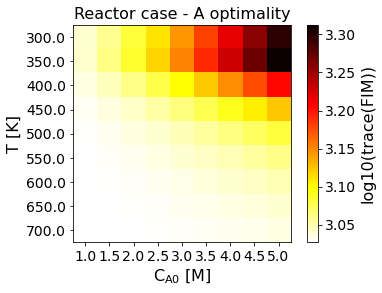

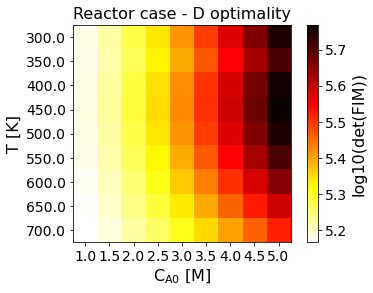

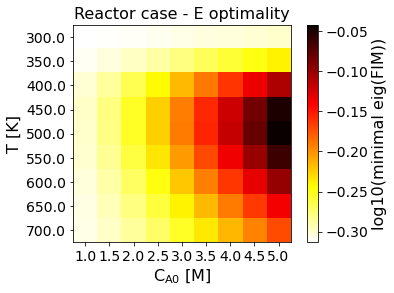

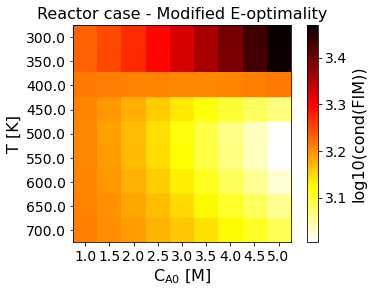

In [21]:
heatmap = Grid_Search_Result(design_ranges, all_fim, store_optimality_name='test_heatmap.csv')

heatmap.heatmap('Reactor case', '$C_{A0}$ [M]', 'T [K]')